In [89]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


## Prediction with explainable AI - Cork City

Let's use this file to predict the prices of houses in Cork City and use explainable AI such as SHAP values to explain the determinants of prices in Cork City. We will then compare this to the same experiment we ran with selected areas of Dublin city.

In [90]:
irl =  pd.read_csv('cork-more-fixed.csv', index_col = 'Unnamed: 0')

In [91]:
irl.head(1)

,Address,County,Price (€),VAT Exclusive,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,PriceInflation,Eircode,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar
94123,"10 Deerpark Court, Friars Walk, Cork",Cork,280000.0,1,1,2,2014,1,Cork City,0,Friars Walk Cork City,529951.22,T12,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264


In [92]:
irl.columns

Index(['Address', 'County', 'Price (€)', 'VAT Exclusive',
       'Description of Property', 'Property Size Description', 'Year', 'Month',
       'Town', 'Apartment', 'Neighbourhood', 'PriceInflation', 'Eircode',
       'Latitude', 'Longitude', 'DistanceCenter', 'DistanceSchool',
       'DistancePark', 'DistanceCar'],
      dtype='object')

In [93]:
irl.drop(columns = ['VAT Exclusive', 'County', 'Address', 'Eircode', 'PriceInflation'], inplace = True)

In [94]:
irl.columns

Index(['Price (€)', 'Description of Property', 'Property Size Description',
       'Year', 'Month', 'Town', 'Apartment', 'Neighbourhood', 'Latitude',
       'Longitude', 'DistanceCenter', 'DistanceSchool', 'DistancePark',
       'DistanceCar'],
      dtype='object')

In [95]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['Price (€)'])

In [96]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['Price (€)'])

In [97]:
# predicting standard
irl['LogPrice (€)'] = np.log(irl['Price (€)'])
irl.drop(columns = ['Price (€)'], inplace = True)
irl.head()

,Description of Property,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Latitude,Longitude,DistanceCenter,DistanceSchool,DistancePark,DistanceCar,LogPrice (€)
94123,1,2,2014,1,238889.733351,0,221996.382933,51.891104,-8.474261,0.808257,0.371367,0.334321,0.607264,12.542545
94124,1,1,2014,1,238889.733351,0,342890.105776,51.844802,-8.312442,12.501636,0.597510,5.440909,11.244529,12.821258
94125,1,1,2014,1,238889.733351,0,150351.141667,51.903869,-8.471192,0.626745,0.323214,0.129914,0.238164,11.775290
94126,1,1,2014,1,238889.733351,0,273439.540807,51.911380,-8.450581,2.096941,0.447549,0.669517,1.805214,11.951180
94127,1,1,2014,1,234741.592357,0,234741.592357,51.882655,-8.507208,2.943974,0.503091,0.823622,2.329469,12.254863


In [98]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [99]:
from tpot import TPOTRegressor
from sklearn.model_selection import RepeatedKFold

## 2021

### TPOT

In [100]:
specific21 = irl[irl['Year'] > 2017]

In [101]:
train_21 = specific21[specific21['Year'] < 2021]

In [102]:
test_21 = specific21[specific21['Year'] == 2021]

In [103]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [104]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [105]:
#cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define search
model = TPOTRegressor(max_time_mins = 6)
model1 = model.fit(x_train_21, y_train_21)

In [106]:
#model1.export('tpot_2021_pipeline.py')

In [107]:
# calculated values
from sklearn.metrics import mean_squared_error
y_predicted_21 = model1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for TPOT AutoML 2021 is: ' + str(mse))

MSE for TPOT AutoML 2021 is: 0.17045773151515015


X does not have valid feature names, but LinearSVR was fitted with feature names


In [108]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for TPOT AutoML 2021 is: ' + str(rmse))

RMSE for TPOT AutoML 2021 is: 0.4128652704153622


In [109]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2137057282331585


In [110]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for TPOT AutoML 2021 is: " + str(mape))

MAPE for TPOT AutoML 2021 is: 0.02363504867682042


In [111]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)

In [112]:
%%capture
import shap
explainer = shap.Explainer(model1.predict, x_test_21)
shap_values = explainer(x_test_21)

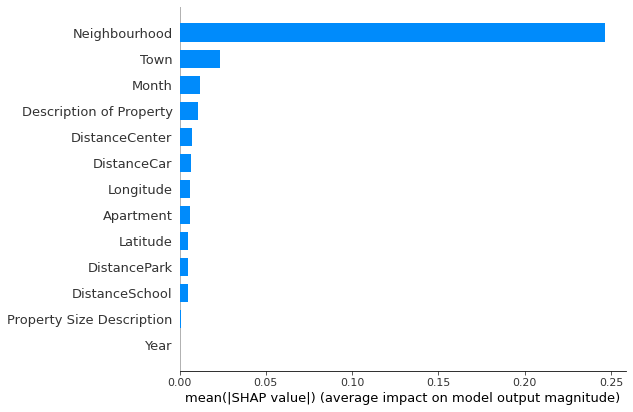

In [113]:
shap.summary_plot(shap_values, x_test_21, plot_type = 'bar')

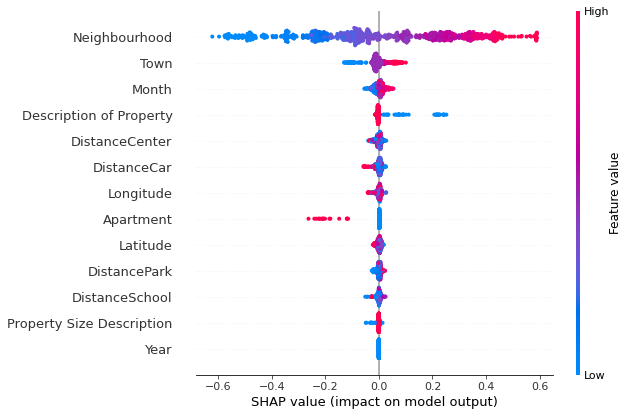

In [127]:
f = plt.figure()
shap.summary_plot(shap_values, x_test_21)
f.savefig("summary_plot21cork.png", bbox_inches = 'tight', dpi = 600)

In [129]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'TPOT AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [131]:
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020

In [133]:
specific20 = irl[irl['Year'] > 2016]

In [135]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [137]:
model = TPOTRegressor(max_time_mins = 6)
model2 = model.fit(x_train_20, y_train_20)

In [139]:
#model2.export('tpot_2020_pipeline.py')

In [141]:
y_predicted_20 = model1.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_predicted_20)
print('MSE for TPOT AutoML 2020 is: ' + str(mse))

MSE for TPOT AutoML 2020 is: 0.12319475224811476


X does not have valid feature names, but LinearSVR was fitted with feature names


In [143]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for TPOT AutoML 2020 is: " + str(mape))

MAPE for TPOT AutoML 2020 is: 0.019102606438943272


In [145]:
median_se = np.square(np.subtract(y_test_20, y_predicted_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15380397426762774


In [147]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for TPOT AutoML 2020 is: ' + str(rmse))

RMSE for TPOT AutoML 2020 is: 0.35099109995570366


In [149]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)

In [151]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns=cnames)

df12 = df12.append({'Algorithm': 'TPOT AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [153]:
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)

In [155]:
%%capture
explainer = shap.Explainer(model2.predict, x_test_20)
shap_values2 = explainer(x_test_20)

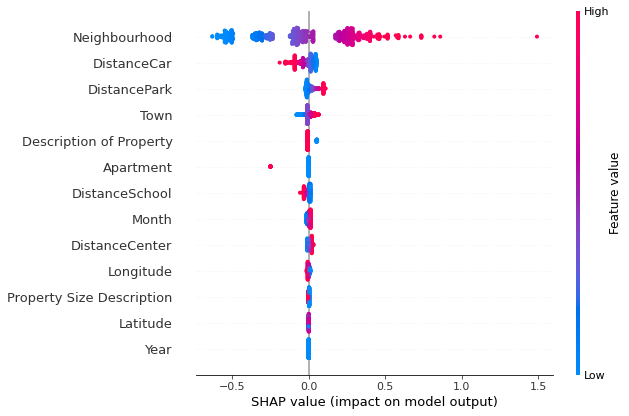

In [157]:
f = plt.figure()
shap.summary_plot(shap_values2, x_test_20)
f.savefig("summary_plot20cork.png", bbox_inches = 'tight', dpi = 600)

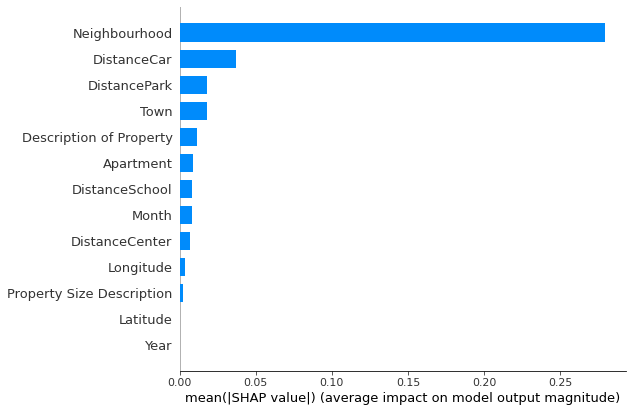

In [159]:
shap.summary_plot(shap_values2, x_test_20, plot_type = 'bar')

### 2019

In [161]:
specific19 = irl[irl['Year'] > 2015]

In [163]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [165]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model3 = model.fit(x_train_19, y_train_19)

In [167]:
#model3.export('tpot_2019_pipeline.py')

In [169]:
y_predicted_19 = model1.predict(x_test_19)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_predicted_19)
print('MSE for TPOT AutoML 2019 is: ' + str(mse))

MSE for TPOT AutoML 2019 is: 0.12208557852421349


X does not have valid feature names, but LinearSVR was fitted with feature names


In [171]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_19, y_predicted_19)
print("MAPE for TPOT AutoML 2019 is: " + str(mape))

MAPE for TPOT AutoML 2019 is: 0.01907122729834233


In [173]:
median_se = np.square(np.subtract(y_test_19, y_predicted_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15614580995878846


In [175]:
rmse = mean_squared_error(y_test_19, y_predicted_19, squared = False)
print('RMSE for TPOT AutoML 2019 is: ' + str(rmse))

RMSE for TPOT AutoML 2019 is: 0.34940746775679177


In [177]:
acc = accuracy_threshold(y_test_19, y_predicted_19, 0.1)

In [179]:
%%capture
explainer = shap.Explainer(model3.predict, x_test_19)
shap_values3 = explainer(x_test_19)

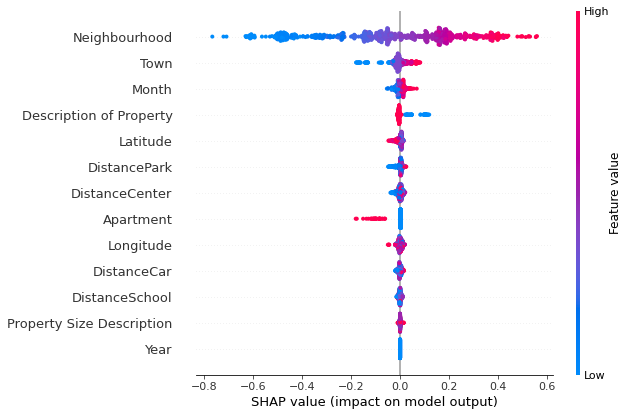

In [181]:
f = plt.figure()
shap.summary_plot(shap_values3, x_test_19)
f.savefig("summary_plot19cork.png", bbox_inches = 'tight', dpi = 600)

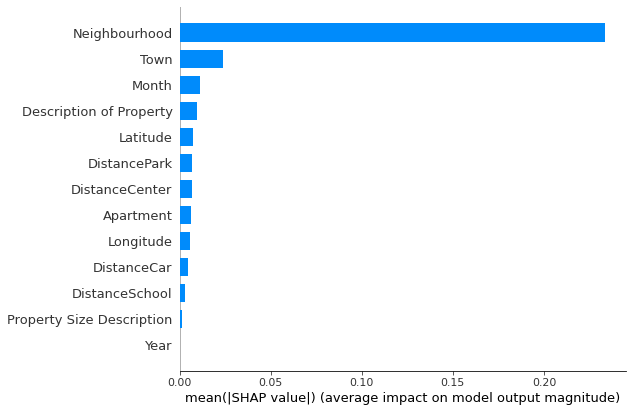

In [183]:
shap.summary_plot(shap_values3, x_test_19, plot_type = 'bar')

In [185]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'TPOT AutoML',
            'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [187]:
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_predicted_19)

### 2018

In [189]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [191]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model4 = model.fit(x_train_18, y_train_18)

In [193]:
#model4.export('tpot_2018_pipeline.py')

In [195]:
y_predicted_18 = model1.predict(x_test_18)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_predicted_18)
print('MSE for TPOT AutoML 2018 is: ' + str(mse))

MSE for TPOT AutoML 2018 is: 0.1366745111555076


X does not have valid feature names, but LinearSVR was fitted with feature names


In [197]:
rmse = mean_squared_error(y_test_18, y_predicted_18, squared = False)
print('RMSE for TPOT AutoML 2018 is: ' + str(rmse))

RMSE for TPOT AutoML 2018 is: 0.36969515976748685


In [199]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_18, y_predicted_18)
print("MAPE for TPOT AutoML 2018 is: " + str(mape))

MAPE for TPOT AutoML 2018 is: 0.02141090883636981


In [201]:
median_se = np.square(np.subtract(y_test_18, y_predicted_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1747700566512556


In [203]:
acc = accuracy_threshold(y_test_18, y_predicted_18, 0.1)

In [205]:
%%capture
explainer = shap.Explainer(model4.predict, x_test_18)
shap_values4 = explainer(x_test_18)

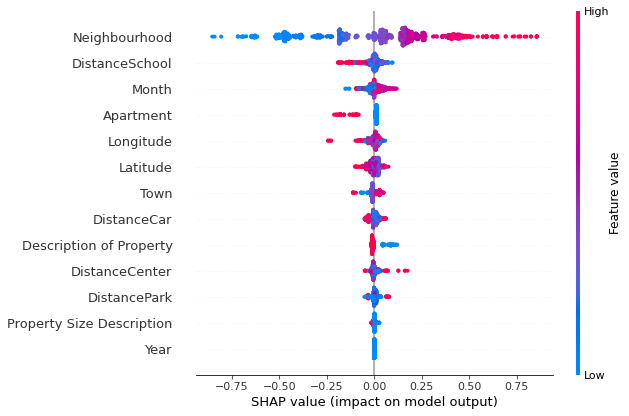

In [207]:
f = plt.figure()
shap.summary_plot(shap_values4, x_test_18)
f.savefig("summary_plot18cork.png", bbox_inches = 'tight', dpi = 600)

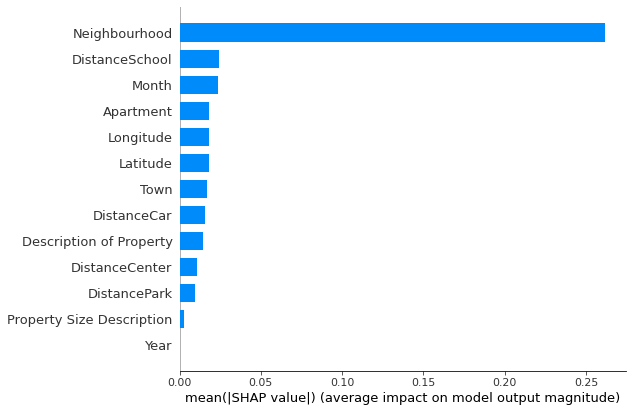

In [209]:
shap.summary_plot(shap_values4, x_test_18, plot_type = 'bar')

In [211]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns=cnames)

df14 = df14.append({'Algorithm': 'TPOT AutoML',
            'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [213]:
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_predicted_18)

### 2017

In [215]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [217]:
model = TPOTRegressor(max_time_mins = 6)
# perform the search // takes ages to run!
model5 = model.fit(x_train_17, y_train_17)

In [219]:
#model5.export('tpot_2017_pipeline.py')

In [221]:
y_predicted_17 = model1.predict(x_test_17)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_predicted_17)
print('MSE for TPOT AutoML 2017 is: ' + str(mse))

MSE for TPOT AutoML 2017 is: 0.19214871128401065


X does not have valid feature names, but LinearSVR was fitted with feature names


In [223]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_17, y_predicted_17)
print("MAPE for TPOT AutoML 2017 is: " + str(mape))

MAPE for TPOT AutoML 2017 is: 0.02550655416521191


In [225]:
median_se = np.square(np.subtract(y_test_17, y_predicted_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.2056341894655113


In [227]:
rmse = mean_squared_error(y_test_17, y_predicted_17, squared=False)
print('RMSE for TPOT AutoML 2017 is: ' + str(rmse))

RMSE for TPOT AutoML 2017 is: 0.43834770591849875


In [229]:
acc = accuracy_threshold(y_test_17, y_predicted_17, 0.1)

In [231]:
%%capture
explainer = shap.Explainer(model5.predict, x_test_17)
shap_values5 = explainer(x_test_17)

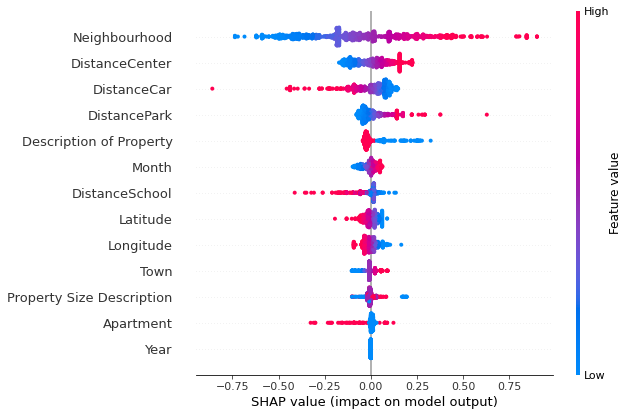

In [233]:
f = plt.figure()
shap.summary_plot(shap_values5, x_test_17)
f.savefig("summary_plot17cork.png", bbox_inches = 'tight', dpi = 600)

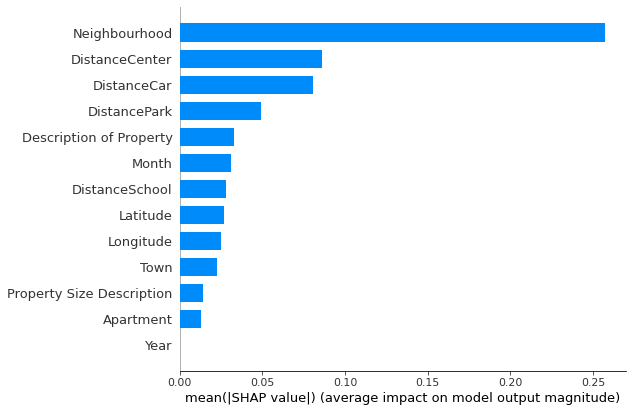

In [235]:
shap.summary_plot(shap_values5, x_train_17, plot_type = 'bar')

In [237]:
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_predicted_17)

In [238]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns=cnames)

df15 = df15.append({'Algorithm': 'TPOT AutoML',
            'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [239]:
vis1 = pd.concat([df11, df12, df13, df14, df15], ignore_index=True)

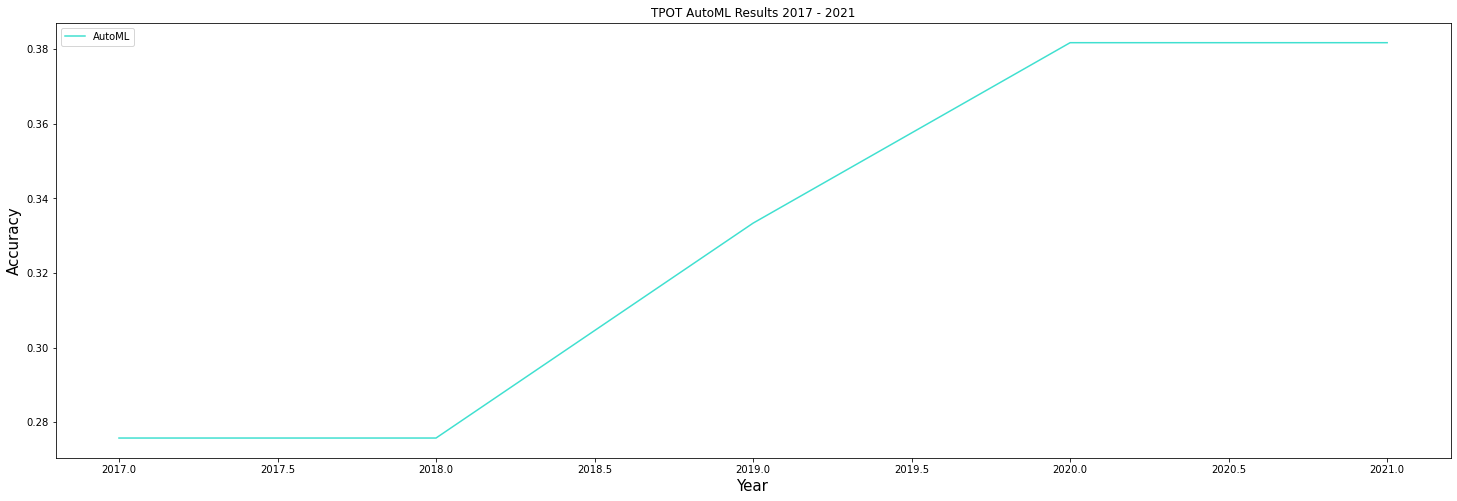

In [240]:
# don't need cross validation same training due to set intervals?
plt.subplots(figsize = (25, 8))
plt.plot(vis1['Year'], vis1['Accuracy'], label = 'AutoML', color = 'turquoise')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('TPOT AutoML Results 2017 - 2021')
plt.legend()
plt.show()

In [241]:
print("Mean accuracy for TPOT AutoML over period 2017-2021 is: " + str(vis1['Accuracy'].mean()))

Mean accuracy for TPOT AutoML over period 2017-2021 is: 0.3296431521892442


In [242]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index = True)
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,11.976659
1,12.421184
2,12.028739
3,12.570716
4,12.367341


In [243]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index = True)
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.077439
1,12.340549
2,11.827289
3,12.060792
4,12.440982


In [244]:
actualvpred = actual.join(pred)

In [245]:
actualvpred.head()

,Actual,Predicted
0,11.976659,12.077439
1,12.421184,12.340549
2,12.028739,11.827289
3,12.570716,12.060792
4,12.367341,12.440982


In [246]:
exp = np.exp(actualvpred)

In [247]:
exp.shape

(4045, 2)

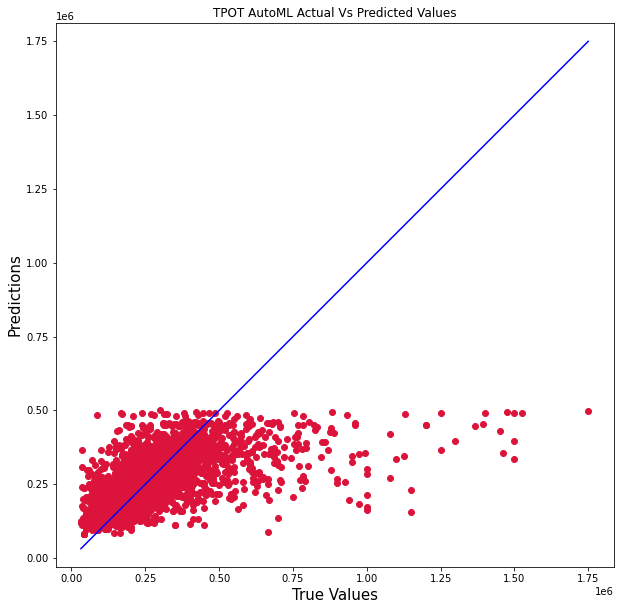

In [248]:
# plot predicted vs actual
## this is using actual prices hence adjusted scale compared to mljar plot
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'crimson')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.title('TPOT AutoML Actual Vs Predicted Values')
plt.axis('equal')
plt.show()